Launching Firefox in headless mode...
Opening https://steamdb.info/sales/?min_reviews=0 ...
Page loaded (networkidle). Taking screenshot...
Browser closed.



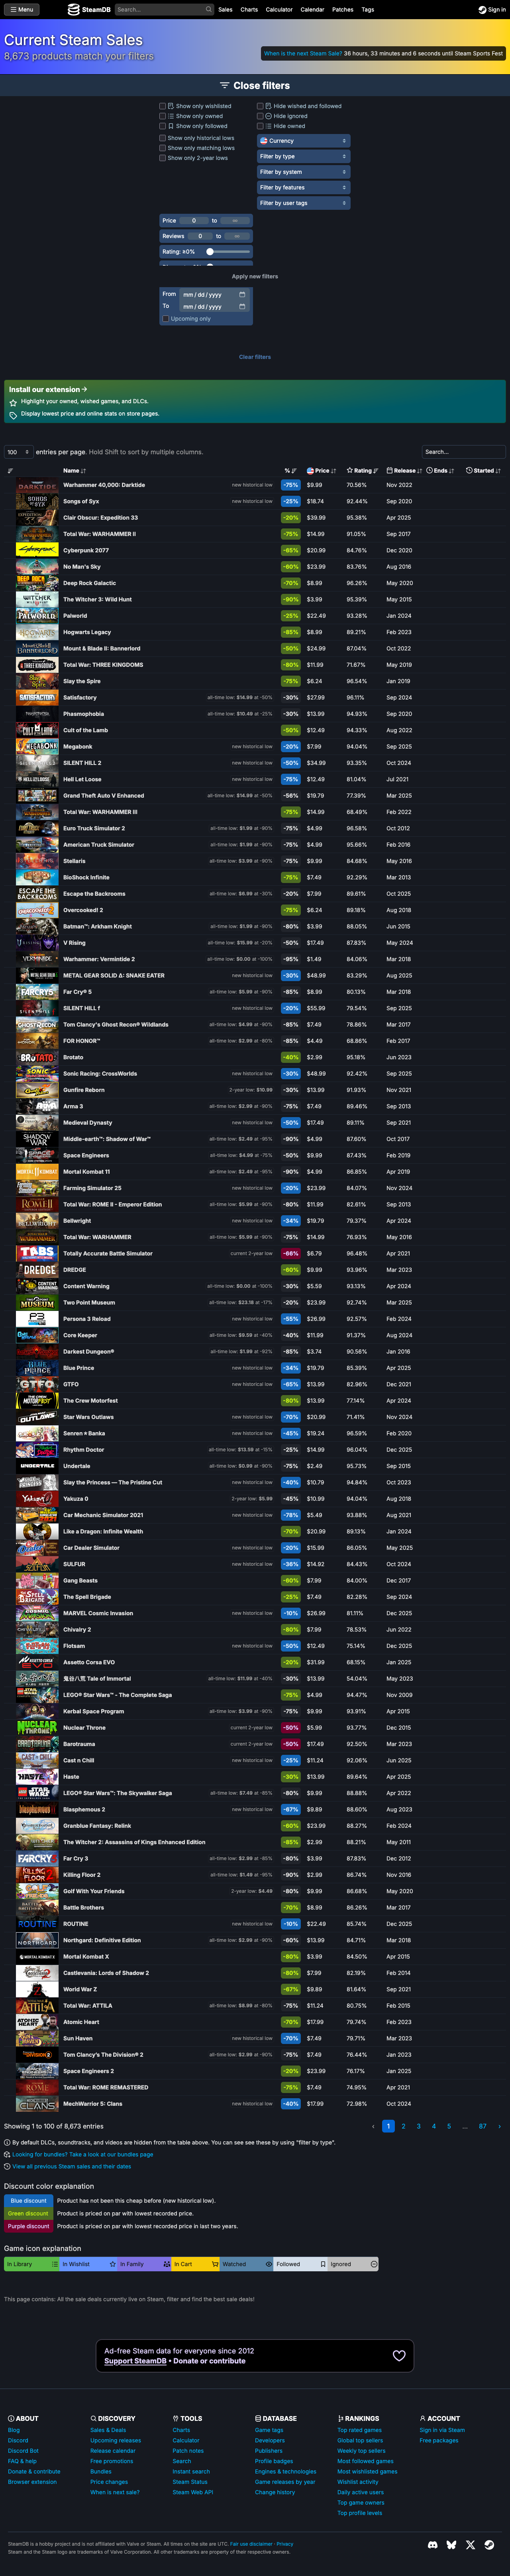


=== Middle text snippet from page body (for debugging) ===
otally Accurate Battle Simulator
current 2-year low
	
-66%
	$6.79	96.48%	Apr 2021		
	
	
DREDGE
	
-60%
	$9.99	93.96%	Mar 2023		
	
	
Content Warning
all-time low:
$0.00
at -100%
	
-30%
	$5.59	93.13%	Apr 2024		
	
	
Two Point Museum
all-time low:
$23.18
at -17%
	
-20%
	$23.99	92.74%	Mar 2025		
	
	
Persona 3 Reload
new historical low
	
-55%
	$26.99	92.57%	Feb 2024		
	
	
Core Keeper
all-time low:
$9.59
at -40%
	
-40%
	$11.99	91.37%	Aug 2024		
	
	
Darkest Dungeon®
all-time low:
$1.99
at -92%
	
-85%
	$3.74	90.56%	Jan 2016		
	
	
Blue Prince
new historical low
	
-34%
	$19.79	85.39%	Apr 2025		
	
	
GTFO
new historical low
	
-65%
	$13.99	82.96%	Dec 2021		
	
	
The Crew Motorfest
	
-80%
	$13.99	77.14%	Apr 2024		
	
	
Star Wars Outlaws
new historical low
	
-70%
	$20.99	71.41%	Nov 2024		
	
	
Senren＊Banka
new historical low
	
-45%
	$19.24	96.59%	Feb 2020		
	
	
Rhythm Doctor
all-time low:
$13.59
at -15%
	
-25%
	$14.99	96.04%	Dec 2025		
	
	
Undert

In [1]:
import asyncio
import nest_asyncio
from io import BytesIO

from playwright.async_api import async_playwright
from IPython.display import display
from PIL import Image

# Allow asyncio to work nicely inside Jupyter
nest_asyncio.apply()

URL = "https://steamdb.info/sales/?min_reviews=0"

async def test_playwright_page():
    print("Launching Firefox in headless mode...")
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        page = await browser.new_page()
        
        print(f"Opening {URL} ...")
        await page.goto(URL, wait_until="networkidle")
        print("Page loaded (networkidle). Taking screenshot...")

        # Take full-page screenshot (in memory only)
        screenshot_bytes = await page.screenshot(full_page=True)
        
        # Get HTML and text so we can inspect what really loaded
        html = await page.content()
        body_text = await page.inner_text("body")

        await browser.close()
        print("Browser closed.\n")

    # Show screenshot in the notebook
    img = Image.open(BytesIO(screenshot_bytes))
    display(img)

    # Show a snippet from the **middle** of the text, which is often more useful
    print("\n=== Middle text snippet from page body (for debugging) ===")
    if len(body_text) > 1200:
        mid = len(body_text) // 2
        snippet = body_text[mid - 600 : mid + 600]
    else:
        snippet = body_text
    print(snippet[:1000])  # cap to 1000 chars just in case

# Run the async function from Jupyter
loop = asyncio.get_event_loop()
loop.run_until_complete(test_playwright_page())


In [ ]:
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright

nest_asyncio.apply()

URL = "https://steamdb.info/sales/?min_reviews=0"

async def fetch_sales_page_html():
    print("Launching Firefox (headless) and loading page...")
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        page = await browser.new_page()

        # 先打开页面
        await page.goto(URL)
        print("Page loaded, waiting for game rows (tr.app)...")

        try:
            # 显式等待表格中的行出现，最多等 15 秒
            await page.wait_for_selector("tr.app", timeout=15000)
            print("✅ Found at least one 'tr.app' row in the DOM.")
        except Exception as e:
            print("❌ Did NOT see any 'tr.app' rows before timeout:", e)

        # 不管有没有找到行，都抓一下当前页面 HTML
        html = await page.content()
        await browser.close()
        print("Browser closed.")
    print(f"HTML length: {len(html)} characters")
    return html

# 实际获取 HTML
loop = asyncio.get_event_loop()
html = loop.run_until_complete(fetch_sales_page_html())


Launching Firefox (headless) and loading page...
Page loaded, grabbing HTML...
Browser closed.
HTML length: 254773 characters


In [3]:
from bs4 import BeautifulSoup
import pandas as pd
from datetime import date

# Parse the HTML we fetched earlier
soup = BeautifulSoup(html, "lxml")

# Each game row has <tr class="app" ...>
rows = soup.select("tr.app")
print(f"Found {len(rows)} rows with class 'app'.")

# Peek at the text of the first row so we know it looks right
if rows:
    first_row = rows[0]
    print("\n=== First row text preview ===")
    print(first_row.get_text(separator=" | ", strip=True)[:500])
else:
    print("No rows found — we may need to adjust the selector.")


Found 100 rows with class 'app'.

=== First row text preview ===
Warhammer 40,000: Darktide | Play For Free | new historical low | -75% | $9.99 | 70.56% | Nov 2022


In [4]:
from datetime import date

today_str = date.today().isoformat()
records = []

print("Scraping game rows into a table...")

total_rows = len(rows)

for idx, row in enumerate(rows, start=1):
    # appid from the <tr> attribute
    appid = row.get("data-appid")

    # Steam store URL from the "info-icon" link
    store_link_tag = row.select_one("td a.info-icon")
    steam_store_url = store_link_tag["href"] if store_link_tag and store_link_tag.has_attr("href") else None

    # Game name from the bold link in the third <td>
    name_tag = row.select_one("td:nth-of-type(3) a.b") or row.select_one("a.b")
    name = name_tag.get_text(strip=True) if name_tag else None

    # Get all <td> cells so we can pull discount, price, rating by position
    cols = row.find_all("td")

    # --- Discount percent (numeric, e.g. 75) ---
    discount_percent = None
    if len(cols) > 3:
        disc_text = cols[3].get_text(strip=True)  # e.g. "-75%"
        if disc_text:
            disc_clean = disc_text.replace("%", "").replace("+", "").replace("-", "")
            try:
                discount_percent = float(disc_clean)
            except ValueError:
                discount_percent = None

    # --- Price (numeric if possible, else None) ---
    price = None
    if len(cols) > 4:
        price_text = cols[4].get_text(strip=True)  # e.g. "$9.99" or "Free"
        if price_text:
            # Remove common currency symbols and commas
            cleaned = price_text.replace("$", "").replace("€", "").replace("£", "").replace(",", "")
            try:
                price = float(cleaned)
            except ValueError:
                # For "Free", "Play For Free", etc., we'll keep it as None
                price = None

    # --- Rating percent (numeric) ---
    rating_percent = None
    if len(cols) > 5:
        # data-sort often has a clean numeric value (e.g. "70.58")
        rating_sort = cols[5].get("data-sort")
        if rating_sort:
            try:
                rating_percent = float(rating_sort)
            except ValueError:
                # Fallback to parsing the visible text like "70.58%"
                rating_text = cols[5].get_text(strip=True).replace("%", "")
                try:
                    rating_percent = float(rating_text)
                except ValueError:
                    rating_percent = None

    records.append({
        "date": today_str,
        "appid": appid,
        "name": name,
        "discount_percent": discount_percent,
        "rating_percent": rating_percent,
        "price": price,
        "steam_store_url": steam_store_url,
    })

    # Simple progress updates so you can see it's working
    if idx == 1 or idx == total_rows or idx % 20 == 0:
        print(f"  Processed {idx}/{total_rows} rows...")

# Turn into a DataFrame
df = pd.DataFrame(records)

print("\nDone! Preview of the first 5 rows:")
display(df.head())

print(f"\nDataFrame shape: {df.shape[0]} rows x {df.shape[1]} columns")


Scraping game rows into a table...
  Processed 1/100 rows...
  Processed 20/100 rows...
  Processed 40/100 rows...
  Processed 60/100 rows...
  Processed 80/100 rows...
  Processed 100/100 rows...

Done! Preview of the first 5 rows:


,date,appid,name,discount_percent,rating_percent,price,steam_store_url
0,2025-12-07,1361210,"Warhammer 40,000: Darktide",75.0,70.56,9.99,https://store.steampowered.com/app/1361210/?cu...
1,2025-12-07,1162750,Songs of Syx,25.0,92.44,18.74,https://store.steampowered.com/app/1162750/?cu...
2,2025-12-07,1903340,Clair Obscur: Expedition 33,20.0,95.38,39.99,https://store.steampowered.com/app/1903340/?cu...
3,2025-12-07,594570,Total War: WARHAMMER II,75.0,91.05,14.99,https://store.steampowered.com/app/594570/?cur...
4,2025-12-07,1091500,Cyberpunk 2077,65.0,84.76,20.99,https://store.steampowered.com/app/1091500/?cu...



DataFrame shape: 100 rows x 7 columns


In [5]:
csv_filename = "steamdb_sales.csv"

# Save to CSV (no index column)
df.to_csv(csv_filename, index=False)

print(f"Saved {df.shape[0]} rows to {csv_filename}")

# Quick preview to confirm it looks good
display(df.head())


Saved 100 rows to steamdb_sales.csv


,date,appid,name,discount_percent,rating_percent,price,steam_store_url
0,2025-12-07,1361210,"Warhammer 40,000: Darktide",75.0,70.56,9.99,https://store.steampowered.com/app/1361210/?cu...
1,2025-12-07,1162750,Songs of Syx,25.0,92.44,18.74,https://store.steampowered.com/app/1162750/?cu...
2,2025-12-07,1903340,Clair Obscur: Expedition 33,20.0,95.38,39.99,https://store.steampowered.com/app/1903340/?cu...
3,2025-12-07,594570,Total War: WARHAMMER II,75.0,91.05,14.99,https://store.steampowered.com/app/594570/?cur...
4,2025-12-07,1091500,Cyberpunk 2077,65.0,84.76,20.99,https://store.steampowered.com/app/1091500/?cu...
